In [1]:
import sys
!{sys.executable} -m pip install scipy numdifftools


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
import numdifftools as nd

In [3]:
def plot(xs : np.array, f, param_dict) -> np.ndarray:
    """
        plot the function f at the points given by the np array xs.

        Input:
            xs : np.array
            f : a function
            param_dict : param dictionary for pyplot.plot  
        Output:
            a plot of f at each of the points xs on a coordinate plane
            returns an ndarray with the points (x, f(x)) that were plotted
    """
    plt.plot(xs, f(xs), **param_dict)
    plt.xlabel("x")
    plt.ylabel("y")

    return np.concatenate((xs.reshape(1,-1),  f(xs).reshape(1,-1)), axis = 0)

def plot_points(points : np.ndarray, param_dict) -> np.ndarray:
    """
        plot a series of ponints given by "points" using parameters
        from the param dict.

        Input:
            points : np.array with shape (d,n), where n is the number
                    of points to be plotted and d is the dimension
                    of the coordinate system
            param_dict : param dictionary for pyplot.plot
        Output
            the points plotted on a coordinate plane using the param dict.
            Returns the points plotted in an ndarry.
    """
    plt.plot(points[0], points[1], **param_dict)
    
    return points


def spiderweb_diagram(f, x_0 : float = 0., n : int = 100) -> np.ndarray:
    """
        Prepare the spiderweb diagram from starting point (x = x_0, y = f(x_0)) and continue for n steps

        Input:
            f : function for fixed-point iteration
            x_0 : initial x value.
            n : number of times to iterate the function.
        Output:
            An ndarray containing the points defining the spiderweb diagram for the fixed-point iteration algorithm 
            of f from (x_0, f(x_0)). Note that this is not the same as the orbit of x_0 on f, because it must include
            the points (x_i, x_i) for each i'th iteration of f.
    """
    # TODO: Dream up a way of doing this without a loop
    points = np.zeros(shape=(n*2 - 1, 2))
    x_i = x_0
    y_i = x_i
    for point in points :
        if x_i == y_i:
            point[0] = x_i
            point[1] = f(x_i)
            y_i = f(x_i)
        else:
            point[0] = y_i
            point[1] = y_i
            x_i = y_i
    
    return points.T # return the transpose of the points arr, because this is better for plotting

def plot_spiderweb_diagram(f, x_0 : float, n : int, delay : int = 0, param_dict : dict = {}) -> np.ndarray :
    """
        generate and plot the spiderweb diagram for n iterations of f starting at x_0, using the
        param_dict dictionary as the parameters of plt.plot()

        Input:
            f : a function for fixed-point iteration
            x_0 : an initial x value. The first point in the result is (x_0, f(x_0))
            delay : the number of iterations to wait before plotting
            n : the number of iterations
        Output:
            a plot of the spiderweb diagram and an nd array of the points in this plot.
            Note that this is not the same as the orbit of x_0 on f because the result
            includes each of the intermediate points (x_i, x_i) for the i'th iteration
            of f. A number of steps equal to the delay parameter are removed from the front 
            of this list.
    """
    web_points = spiderweb_diagram(f, x_0, n)
    plotted_web_points = web_points[:,(2*delay)::]
    plot_points(plotted_web_points, param_dict)
    
    return web_points

def newtons_method(f, x_0 : float, n : int) -> np.ndarray :
    """
        generates the points for the plot of n steps of Newton's method applied to f starting at x_0

        Input:
            f : a function on which to apply Newton's method
            x_0 : an initial x value. The first point in the result is (x_0, 0)
            n : the number of iterations
        Output
            An ndarray of points to plot Newton's method applied n times to f starting at x_0.
            Note that this is not the sequence of points generated by Newton's method, for it 
            contains each of the intermediate points (x_i, 0) for the i'th iteration of Newton's method.
    """
    points = np.zeros(shape=(2 * n, 2))
    x_i = x_0
    y_i = 0
    
    for point in points:
        if y_i == 0:
            # set the values of the current point
            point[0] = x_i
            point[1] = 0
            
            # update y_i. x_i remains the same
            y_i = f(x_i)
        else:
            # set the values of the current point
            point[0] = x_i
            point[1] = y_i

            # use scipy to compute the derivative of f at x_i, which is the slope of the tangent line
            df_dx = nd.Derivative(f, n = 1)
            dx_i = df_dx(x_i)

            # use df_dx to compute the x intercept (x_int) of the tangent line
            x_int = (-y_i + dx_i * x_i) / dx_i
            
            # update x_i and y_i
            x_i = x_int
            y_i = 0
    
    return points.T

def plot_newtons_method(f, x_0 : float, n : int, delay : int = 0, param_dict : dict = {}) -> np.ndarray:
    """
        generates and plots n steps of Newton's method returning the points required to plot it

        Input:
            f : a function on which to apply Newton's method
            x_0 : an initial x value. The first point in the result is (x_0, 0)
            n : the number of iterations
            param_dict : a params dict for plotting the points. Must not specify 'linestyle'
                         or 'label'.
        Output
            a plot of Newton's method applied n times to f starting at x and an ndarray with
            the points on that plot. Note that this is not the sequence of points generated by
            Newton's method, for it contains each of the intermediate points (x_i, 0) for the
            i'th iteration of Newton's method. A number of iterations equal to delay from the
            start of the list is removed.
    """
    points = newtons_method(f, x_0, n)

    for i in range(2*n - 1): # stops one entry early on purpose, because the loop body refers to the next point.
        if i % 2 == 0:
            # dashed line to the next point (x_i, f(x_i))
            linestyle = "--"
        else:
            # solid line to the next intercept
            linestyle = "-"

        if i == 2*n - 2:
            param_dict['label'] = "Newton's Method"

        if i >= 2*delay: 
            plt.plot([points[0,i], points[0,i+1]],[points[1,i], 
                                points[1,i+1]], linestyle = linestyle, **param_dict)
        
    return points

def sym_arr(range : float, steps : int) -> np.array :
    """
        creates a symmetrical numpy array with evenly spaced entries centered on 0.
        Input:
            range : the range of the entries in the array (max - min)
            steps : the number of entries in the array
        Output:
            a symmetrical array of "steps" entries, with a range of "range."
    """
    # TODO: Handle the case that steps is 0 or negative.

    # make an intermediate array of all ones with an extra entry at the beginning.
    # set said entry to 0 to ensure that the range is correct.
    intermediate_arr = np.ones((steps + 1, ))
    intermediate_arr[0] = 0

    # use the cumsum function to set the entries of the intermediate array to 
    # a series of consecutive integers. Shift and scale entries to arrive at
    # the desired array.
    intermediate_arr = intermediate_arr.cumsum() / steps * range - (range / 2)
    
    return intermediate_arr

def positive_arr(range : float, steps : int) -> np.array :
    """
        creates a numpy array with evenly spaced entries spanning 0 to "range".
        Name is derived from the fact this generates points on the nonzero real line.
        Input:
            range : the range of the entries in the array (range - 0)
            steps : the number of entries in the arrayd
        Output:
            an array of "steps" entries, starting at 0 with a range of "range."
    """
    return np.linspace(0, range, num = steps)

In [22]:
# This cell defines constants for use throughout the rest of this workbook

# place the function you want to examine in the lambda on the next line
a = 3.6
f = lambda x : a * x * (1-x)
y_x = lambda x : x

plot_range = 1.00
line_range = 1.00
steps = 100
zoom_factor = 0.1

# make a numpy array of "steps" x values with range "range" that is symmetric about the y-axis
xs = positive_arr(plot_range, steps)
line_xs = positive_arr(line_range, steps)
x_axis = np.array([[0, 1.2 * plot_range],[0,0]]) # two points to draw the x-axis

min_y = 0
max_y = max(f(xs).max(), plot_range / 2 + zoom_factor * (plot_range / 2))
y_axis = np.array([[0,0],[min_y, max_y]])

f_color = "blue"
fixed_color = "orange"
axis_plot_dict = {"color": "black", "linestyle": "--"}
f_plot_dict = {"color": f_color, "linestyle": "-", "label":"f(x)"}
fixed_plot_dict = {"color": fixed_color, "linestyle": "-", "label":"y = x"}

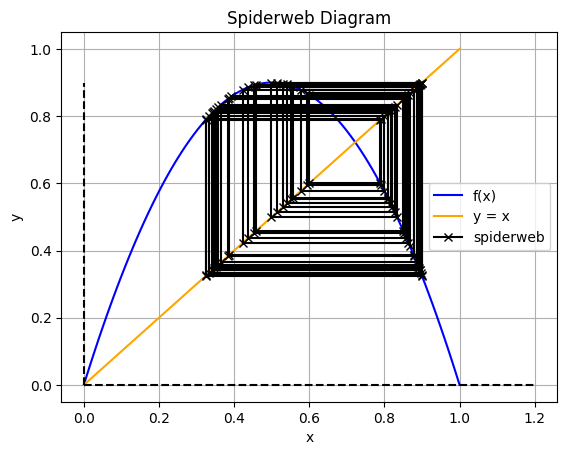

In [23]:
# Testing out Spiderweb functionality

# Plot the function f, the line y = x, and the x and y axes on the coordinate plane
plt.title(f'Spiderweb Diagram')
f_x = plot(xs, f, f_plot_dict)
fixed_line = plot(line_xs, y_x, fixed_plot_dict)
plot_points(x_axis, axis_plot_dict)
plot_points(y_axis, axis_plot_dict)

# args for the spiderweb
x_0 = 1/2
n = 10000
spiderweb_dict = {"color":"black","linestyle":"-","marker":"x","label":"spiderweb"}

# generate the points in the spiderweb diagram and plot it on the coordinate plain
web_points = plot_spiderweb_diagram(f, x_0, n, 9950, spiderweb_dict)

plt.grid()
plt.legend()
plt.show()

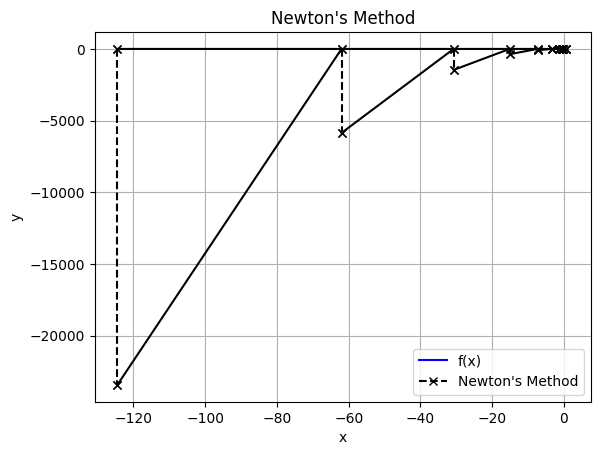

In [6]:
plt.title("Newton's Method")
plot(xs, f, f_plot_dict)
plot_points(x_axis, axis_plot_dict)
plot_points(y_axis, axis_plot_dict)

# parameters for Newton's Method
x_0 = 0.499
n = 10
newtons_plot_dict = {"color":"black", "marker":"x"} # the function takes care of the linestyles and the label.

newtons_points = plot_newtons_method(f, x_0, n, 0, newtons_plot_dict)

plt.grid()
plt.legend()
plt.show()